# Sales Analysis

#### In this project we analyze and answer business questions related to about 12 months worth of sales data. The data contains hundreds of thousands of electronics store purchases broken down by month, product type, cost, purchase address, etc. 

#### Import necessary libraries

In [1]:
import os
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

#### Merge data from each month into one CSV

In [2]:
path = "./Sales_Data"
out_path = './Sales_Data_Aggregated'
files = [file for file in os.listdir(path) if not file.startswith('.')] # Ignore hidden files

all_months_data = pd.DataFrame()

for file in files:
    current_data = pd.read_csv(path+"/"+file)
    all_months_data = pd.concat([all_months_data, current_data])
    
all_months_data.to_csv(out_path+"/"+"all_data.csv", index=False)
    

#### Read in updated dataframe

In [3]:
all_data = pd.read_csv(out_path+"/"+"all_data.csv")
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


##### Drop rows of NAN

In [4]:
# Find NAN

nan_df = all_data[all_data.isna().any(axis=1)]
display(nan_df.head())

print("\n\n# rows in original data: {}\n# NAN rows: {}\n% of NAN rows dropped: {}".format(len(all_data),
                                                                                          len(nan_df),
                                                                                          len(nan_df)/len(all_data)*100))

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
1,NaN,NaN,NaN,NaN,NaN,NaN
356,NaN,NaN,NaN,NaN,NaN,NaN
735,NaN,NaN,NaN,NaN,NaN,NaN
1433,NaN,NaN,NaN,NaN,NaN,NaN
1553,NaN,NaN,NaN,NaN,NaN,NaN




# rows in original data: 186850
# NAN rows: 545
% of NAN rows dropped: 0.29167781643029167


In [5]:
all_data = all_data.dropna(how='all')
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001"


In [6]:
all_data.isnull().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

##### Get rid of text in order date column

- Seems like the Order Data column has certain values that aren't of date format. 



- An error suggested that **'Order Date'** was present in the columns and didn't allow for datetime conversion

In [7]:
all_data.loc[(all_data['Order Date'].str.lower().str.contains('order')), 'Order Date']

519       Order Date
1149      Order Date
1155      Order Date
2878      Order Date
2893      Order Date
             ...    
185164    Order Date
185551    Order Date
186563    Order Date
186632    Order Date
186738    Order Date
Name: Order Date, Length: 355, dtype: object

In [8]:
index_to_drop = all_data.loc[(all_data['Order Date'].str.lower().str.contains('order')), 'Order Date'].index

index_to_drop

Int64Index([   519,   1149,   1155,   2878,   2893,   3036,   3209,   3618,
              4138,   4645,
            ...
            183808, 184489, 184666, 184779, 185118, 185164, 185551, 186563,
            186632, 186738],
           dtype='int64', length=355)

In [9]:
# We will drop these columns

all_data.drop(index = index_to_drop, inplace = True)

any(all_data.loc[(all_data['Order Date'].str.lower().str.contains('order')), 'Order Date'])

False

#### Make columns correct type

In [10]:
all_data.dtypes

Order ID            object
Product             object
Quantity Ordered    object
Price Each          object
Order Date          object
Purchase Address    object
dtype: object

- We need to convert Quantity Ordered and Price Each to numerical.

In [11]:
all_data['Quantity Ordered'] = pd.to_numeric(all_data['Quantity Ordered'])
all_data['Price Each'] = pd.to_numeric(all_data['Price Each'])

### Augment data with additional columns

#### Add month column 

In [12]:
all_data['Order Date'] = pd.to_datetime(all_data['Order Date'])

In [13]:
all_data['Month'] = all_data['Order Date'].dt.month

all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4


#### Add city column

In [14]:
def get_city(address):
    return address.split(",")[1].strip(" ")

def get_state(address):
    return address.split(",")[2].split(" ")[1]

all_data['City'] = all_data['Purchase Address'].apply(lambda x: f"{get_city(x)}  ({get_state(x)})")
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,City
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,Dallas (TX)
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,Boston (MA)
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles (CA)
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles (CA)
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,Los Angeles (CA)


## Data Exploration!

#### Question 1: What was the best month for sales? How much was earned that month? 

In [15]:
all_data['Revenue'] = all_data['Quantity Ordered'] * all_data['Price Each']

In [16]:
Monthly_Rev = all_data.groupby(['Month']).sum()

Monthly_Rev

,Quantity Ordered,Price Each,Revenue
Month,,,
1,10903,1811768.38,1822256.73
2,13449,2188884.72,2202022.42
3,17005,2791207.83,2807100.38
4,20558,3367671.02,3390670.24
5,18667,3135125.13,3152606.75
6,15253,2562025.61,2577802.26
7,16072,2632539.56,2647775.76
8,13448,2230345.42,2244467.88
9,13109,2084992.09,2097560.13


range(1, 13)


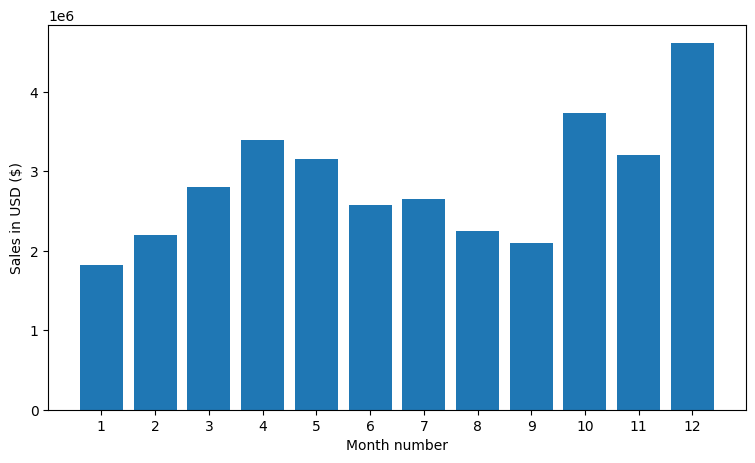

In [17]:
import matplotlib.pyplot as plt

months = range(1,13)
print(months)

plt.figure(figsize=(9,5))
plt.bar(months,Monthly_Rev['Revenue'])
plt.xticks(months)
plt.ylabel('Sales in USD ($)')
plt.xlabel('Month number')
plt.show()

- Seems like December generated the most revenue (around 4.6 Million $)

> Could be that December has Christmas and New year and people might be buying a lot of products

#### Question 2: What city sold the most product?

In [18]:
Revenue_by_city = all_data.groupby(['City']).sum()

Revenue_by_city

,Quantity Ordered,Price Each,Month,Revenue
City,,,,
Atlanta (GA),16602,2779908.20,104794,2795498.58
Austin (TX),11153,1809873.61,69829,1819581.75
Boston (MA),22528,3637409.77,141112,3661642.01
Dallas (TX),16730,2752627.82,104620,2767975.40
Los Angeles (CA),33289,5421435.23,208325,5452570.80
New York City (NY),27932,4635370.83,175741,4664317.43
Portland (ME),2750,447189.25,17144,449758.27
Portland (OR),11303,1860558.22,70621,1870732.34
San Francisco (CA),50239,8211461.74,315520,8262203.91


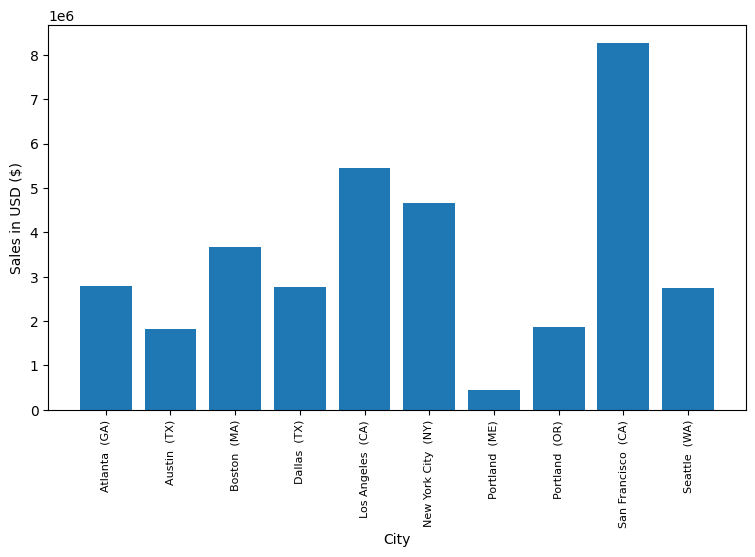

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
plt.bar(x = Revenue_by_city.index, height = Revenue_by_city['Revenue'])
plt.ylabel('Sales in USD ($)')
plt.xlabel('City')
plt.xticks(rotation='vertical', size=8)
plt.show()

- San Francisco seems to generate most probably due to the fact that it is a big & bustling city and maybe the marketing is much better there.

#### Question 3: What time should we display advertisements to maximize likelihood of customer's buying product?

In [20]:
# Add hour column

all_data['Hour'] = all_data['Order Date'].dt.hour
all_data['Minute'] = all_data['Order Date'].dt.minute
all_data['Count'] = 1
all_data.head()


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,City,Revenue,Hour,Minute,Count
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,Dallas (TX),23.90,8,46,1
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,Boston (MA),99.99,22,30,1
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles (CA),600.00,14,38,1
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles (CA),11.99,14,38,1
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,Los Angeles (CA),11.99,9,27,1


In [21]:
Hourly_rev_pdtcount = all_data.groupby('Hour').agg(Count = ('Count', 'count'), Revenue = ('Revenue', 'sum'))

Hourly_rev_pdtcount.head()

,Count,Revenue
Hour,,
0,3910,713721.27
1,2350,460866.88
2,1243,234851.44
3,831,145757.89
4,854,162661.01


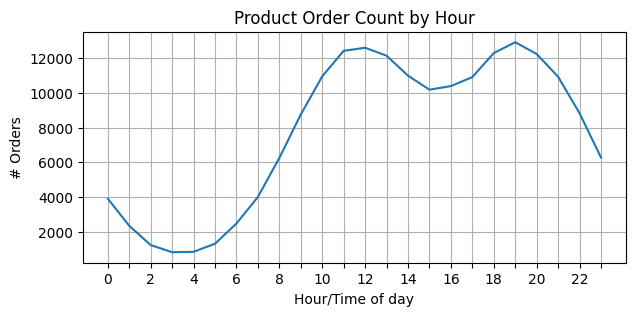

In [22]:
plt.figure(figsize=(7,3))
plt.plot(Hourly_rev_pdtcount.index, Hourly_rev_pdtcount['Count'])
plt.title('Product Order Count by Hour')
plt.ylabel('# Orders')
plt.xlabel('Hour/Time of day')
plt.xticks(ticks = range(0,24), labels= [i if i%2 == 0 else '' for i in range(0,24)])
plt.grid()
plt.show()

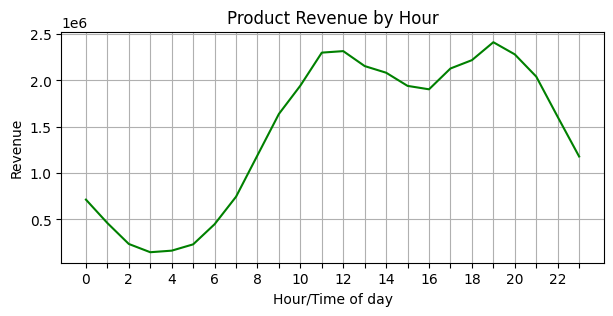

In [23]:
plt.figure(figsize=(7,3))
plt.plot(Hourly_rev_pdtcount.index, Hourly_rev_pdtcount['Revenue'], color = 'green')
plt.title('Product Revenue by Hour')
plt.xticks(ticks = range(0,24), labels= [i if i%2 == 0 else '' for i in range(0,24)])
plt.ylabel('Revenue')
plt.xlabel('Hour/Time of day')
plt.grid()
plt.show()

- We see that the peak time/hour seems to be one at **11am - 12pm** and the other at **7pm - 8pm**. So we could advertise more during these hours to maximize product purchase.

#### Looking at it city wise...

In [24]:
all_data.City.unique()

array(['Dallas  (TX)', 'Boston  (MA)', 'Los Angeles  (CA)',
       'San Francisco  (CA)', 'Seattle  (WA)', 'Atlanta  (GA)',
       'New York City  (NY)', 'Portland  (OR)', 'Austin  (TX)',
       'Portland  (ME)'], dtype=object)

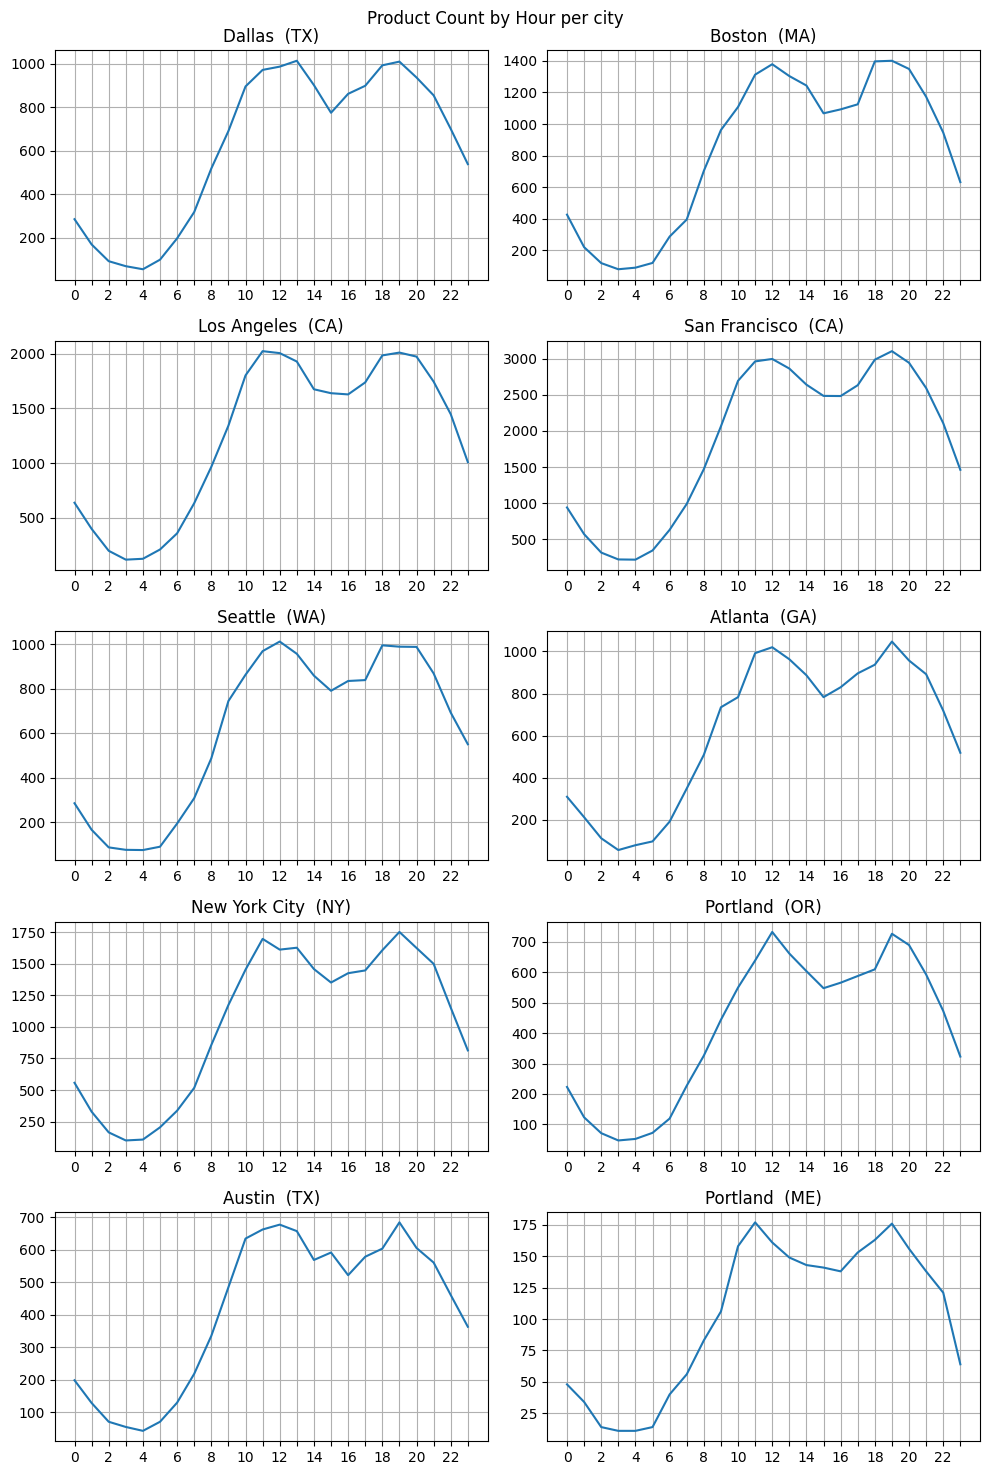

In [25]:
cities = all_data.City.unique()
plt.figure(figsize=(10, 15))

for p,q in enumerate(cities):
        
    plot_df = all_data.loc[all_data.City == q, ['Count','Hour']].groupby('Hour').agg(Count = ('Count', 'count')) 

    plt.subplot(5,2,p+1)
    plt.plot(plot_df.index, plot_df['Count'])
    plt.suptitle('Product Count by Hour per city')
    plt.title(q)
    plt.xticks(ticks = range(0,24), labels= [i if i%2 == 0 else '' for i in range(0,24)])
    plt.grid()
    plt.tight_layout()


- Seems like for all cities, the trend seems to be more or less same except for the quantity sold count. So across all cities except Portland (OR), Portland (ME) and Austin (TX), we can try to advertise around 11am and 7 pm.

#### Question 4: What products are most often sold together?

In [26]:
all_data

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,City,Revenue,Hour,Minute,Count
0,176558,USB-C Charging Cable,2,11.95,2019-04-19 08:46:00,"917 1st St, Dallas, TX 75001",4,Dallas (TX),23.90,8,46,1
2,176559,Bose SoundSport Headphones,1,99.99,2019-04-07 22:30:00,"682 Chestnut St, Boston, MA 02215",4,Boston (MA),99.99,22,30,1
3,176560,Google Phone,1,600.00,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles (CA),600.00,14,38,1
4,176560,Wired Headphones,1,11.99,2019-04-12 14:38:00,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles (CA),11.99,14,38,1
5,176561,Wired Headphones,1,11.99,2019-04-30 09:27:00,"333 8th St, Los Angeles, CA 90001",4,Los Angeles (CA),11.99,9,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...
186845,259353,AAA Batteries (4-pack),3,2.99,2019-09-17 20:56:00,"840 Highland St, Los Angeles, CA 90001",9,Los Angeles (CA),8.97,20,56,1
186846,259354,iPhone,1,700.00,2019-09-01 16:00:00,"216 Dogwood St, San Francisco, CA 94016",9,San Francisco (CA),700.00,16,0,1
186847,259355,iPhone,1,700.00,2019-09-23 07:39:00,"220 12th St, San Francisco, CA 94016",9,San Francisco (CA),700.00,7,39,1
186848,259356,34in Ultrawide Monitor,1,379.99,2019-09-19 17:30:00,"511 Forest St, San Francisco, CA 94016",9,San Francisco (CA),379.99,17,30,1


- We see that **order ID = 176560**, we see that **2** different products were bought. This means we can look at all the orders to find what and how many different products were bought together. 


- This way, we can find all such order IDs and see which duo/trio/more were bought the most.

In [27]:
# Lets look at the different products bought together. (same ORDER ID)
# We will ignore cases where only 1 product was bought.

product_groups = all_data.groupby(['Order ID']).count().sort_values(by = 'Count', ascending = False)[['Product','Count']]

product_groups[product_groups.Count > 1].groupby('Count').count()

,Product
Count,
2,6778
3,340
4,17
5,1


- We see that there are close to 6800 purchases where 2 products were bought together in a single transaction. 

- It is close to 350 for 3 products.



> In these groups, we will try to find out which pairs/trios were purchased the most.

In [28]:
df = all_data[all_data['Order ID'].duplicated(keep=False)]

df['Product Group'] = df.groupby('Order ID')['Product'].transform(lambda x: ','.join(sorted(x)))
pdt_groups_df = df[['Order ID', 'Product Group']].drop_duplicates()

In [29]:
from itertools import combinations
from collections import Counter

count_2 = Counter()
count_3 = Counter()

for row in pdt_groups_df['Product Group']:
    
    row_list = row.split(',')
    
    if len(row_list) >= 2:
        
        count_2.update(Counter(combinations(row_list, 2)))
        
    if len(row_list) >= 3:
        
        count_3.update(Counter(combinations(row_list, 3)))

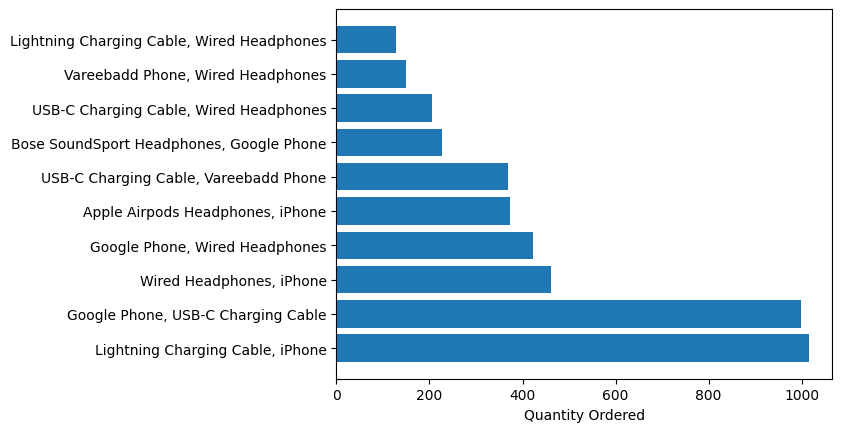

In [30]:
# 10 most commonly bought product duos

item_duo = []
duo_count = []
for key,value in count_2.most_common(10):
    
    item_duo.append(', '.join(key))
    duo_count.append(value)
    
plt.barh(y = item_duo, width = duo_count)
plt.yticks(fontsize=10)
plt.xlabel('Quantity Ordered')
plt.show()

> From what we saw earlier, out of nearly 6800 products bought together as a duo, we see from the above chart that **(Lightning Charging Cable, iPhone)** seems to be the most commonly bought duo with **1000+ sold**.

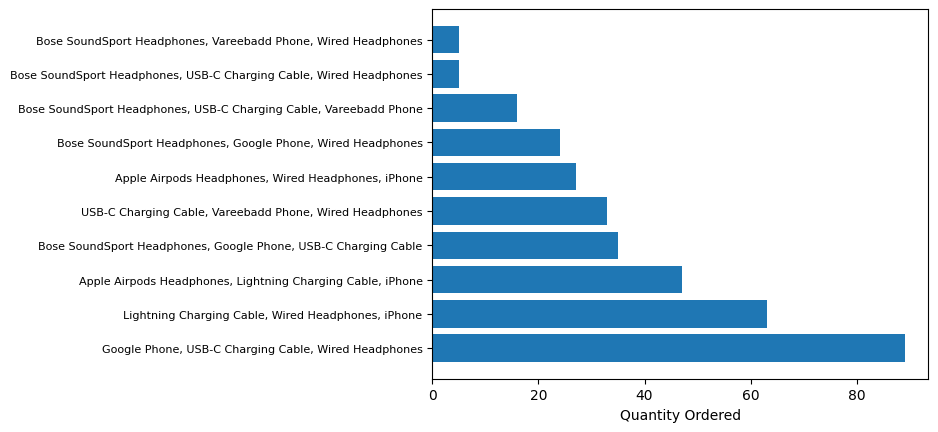

In [31]:
# 10 most commonly bought product trios

item_trio = []
trio_count = []

for key,value in count_3.most_common(10):
    
    item_trio.append(', '.join(key))
    trio_count.append(value)
    
plt.barh(y = item_trio, width = trio_count)
plt.yticks(fontsize=8)
plt.xlabel('Quantity Ordered')
plt.show()

> For the most bought duos/trios, we can maybe look at pairing them up and providing overall discount to reach more customers.


> We could market/advertise the others items from the group when any one item of the group is being purchased by customers.


> We could also offer promotion for the other products in the group when the others are being bought.

#### What product sold the most? Why do you think it sold the most?

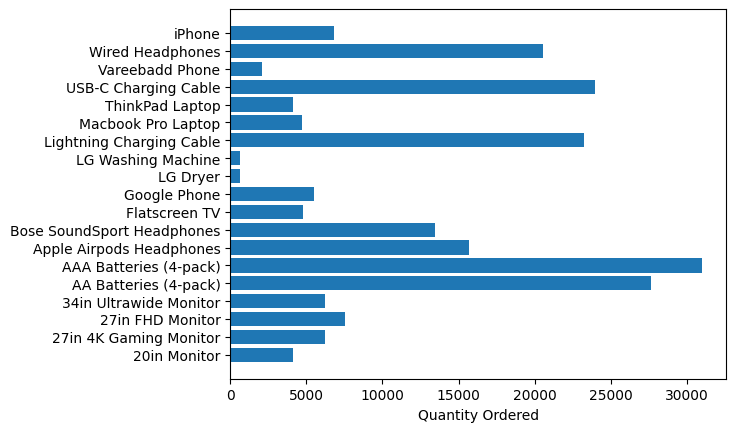

In [32]:
product_group = all_data.groupby('Product')
quantity_ordered = product_group.sum()['Quantity Ordered']

keys = [pair for pair, df in product_group]
plt.barh(y = keys, width = quantity_ordered)
plt.xlabel('Quantity Ordered')
# plt.ylabel('Product', size = 14)
plt.yticks(fontsize=10)
plt.show()

> We see that the most ordered item is **AAA Batteries** and the least is the **LG Dryer**. Ofcourse, the latter is a huge and complex electronic device that costs probably 100 - 1000X the former. Also it is bought by people just once and used for years. That's why among handheld devices, even they cost a lot, they are being sold fairly well since there is demand for it.

<Figure size 1200x1000 with 0 Axes>

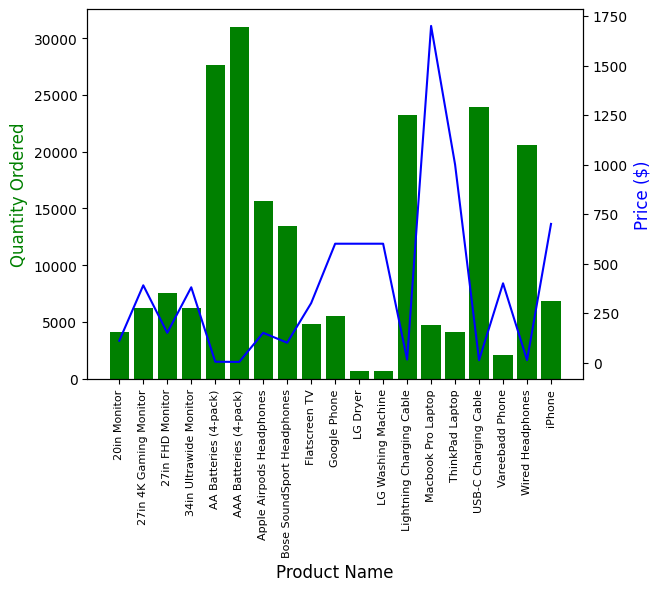

In [33]:
prices = all_data.groupby('Product').mean()['Price Each']

plt.figure(figsize=(12,10))
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(keys, quantity_ordered, color='g')
ax2.plot(keys, prices, color='b')

ax1.set_xlabel('Product Name', size = 12)
ax1.set_ylabel('Quantity Ordered', color='g', size = 12)
ax2.set_ylabel('Price ($)', color='b', size = 12)
ax1.set_xticklabels(keys, rotation='vertical', size=8)

fig.show()

- We can observe a negative correlation between price and quantity ordered except for certain cases which could be explained by demand.


- The devices have a decent demand among students and working professionals and hence the high order quantity values.



- Overall it is clear that most commonly bought items are daily/weekly needs and cost low.